Data loaded successfully.
Data filtered for season >= 2003.
Number of features 62
oof season 2003 mae: 8.968004233090566
oof season 2004 mae: 7.932508687336101
oof season 2005 mae: 7.564109590418068
oof season 2006 mae: 8.9012294155649
oof season 2007 mae: 7.841895386082211
oof season 2008 mae: 9.989559252564504
oof season 2009 mae: 9.173277919823562
oof season 2010 mae: 8.874525395282793
oof season 2011 mae: 9.686107021648692
oof season 2012 mae: 8.60062262441119
oof season 2013 mae: 10.292826575186645
oof season 2014 mae: 10.24458923985083
oof season 2015 mae: 7.498212397704498
oof season 2016 mae: 10.601813270494215
oof season 2017 mae: 9.938217537331148
oof season 2018 mae: 10.569328335296905
oof season 2019 mae: 8.99807179133989
oof season 2021 mae: 10.535660798206578
oof season 2022 mae: 10.743824157822308
oof season 2023 mae: 9.638746645664533
oof season 2024 mae: 9.536930495191976
average mae: 9.339526703348195


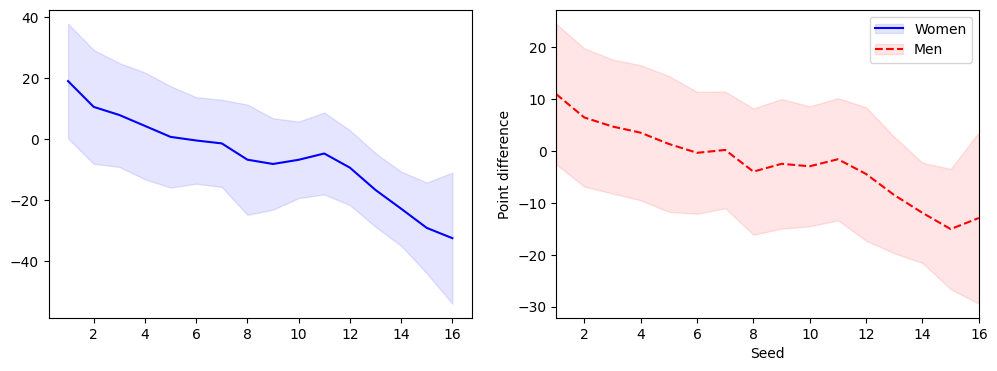

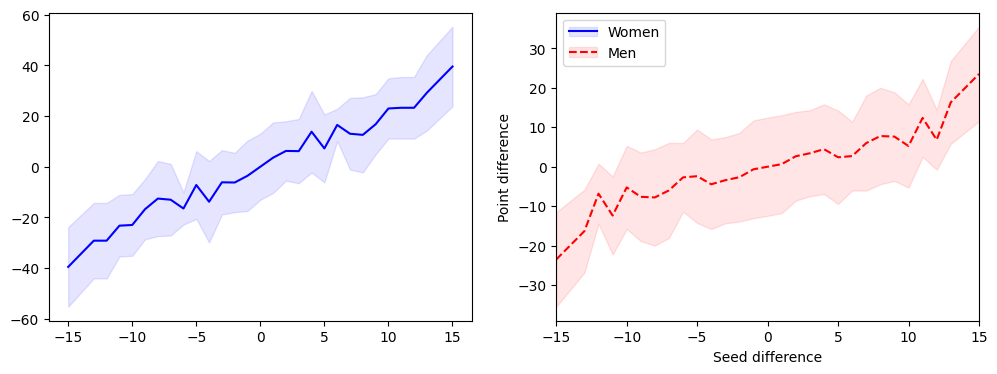

In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import import_ipynb
from Training import Trainer


class Prediction:
    def __init__(self):
        pass

    def get_predictions(self):
        self.X = X
        return self.X
    
trainer = Trainer()
tourneyData, ss_T1, ss_T2, seeds_T1, seeds_T2, oof_ss, oof_preds, oof_targets, features, models = trainer.get_trained_models()

<Axes: xlabel='pred_pointdiff', ylabel='average_win_pct'>

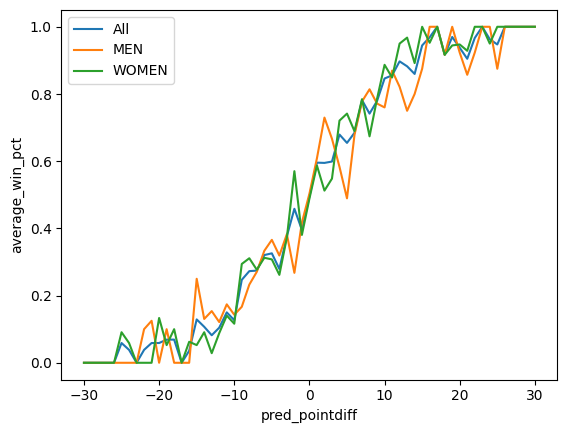

In [2]:
df = pd.DataFrame(
    {"Season": oof_ss, "pred": oof_preds, "label": [(t > 0) * 1 for t in oof_targets], "men_women": tourneyData["men_women"]}
)
df["pred_pointdiff"] = df["pred"].astype(int)

xdf_all = df.clip(-30, 30).groupby("pred_pointdiff")["label"].mean().reset_index(name="average_win_pct")
xdf_men = df.clip(-30, 30).loc[df["men_women"] == 0].groupby("pred_pointdiff")["label"].mean().reset_index(name="average_win_pct")
xdf_women = df.clip(-30, 30).loc[df["men_women"] == 1].groupby("pred_pointdiff")["label"].mean().reset_index(name="average_win_pct")

seaborn.lineplot(x=xdf_all["pred_pointdiff"], y=xdf_all["average_win_pct"], label="All")
seaborn.lineplot(x=xdf_men["pred_pointdiff"], y=xdf_men["average_win_pct"], label="MEN")
seaborn.lineplot(x=xdf_women["pred_pointdiff"], y=xdf_women["average_win_pct"], label="WOMEN")

brier: 0.17134150952150362


Text(0, 0.5, 'Win probability')

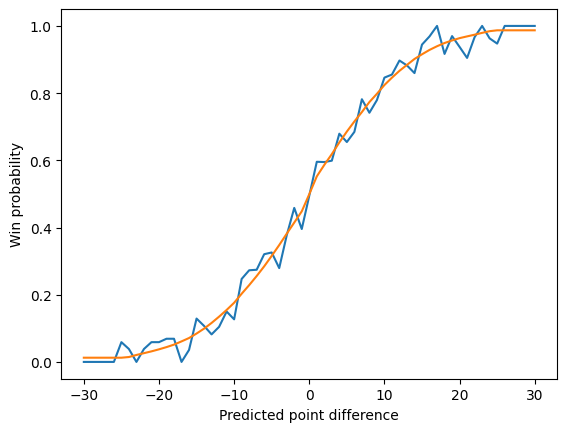

In [3]:
from scipy.interpolate import UnivariateSpline
from sklearn.metrics import brier_score_loss


t = 25
dat = list(zip(oof_preds, np.array(oof_targets)>0))
dat = sorted(dat, key = lambda x: x[0])
pred, label = list(zip(*dat))
spline_model = UnivariateSpline(np.clip(pred, -t, t), label, k=5)
spline_fit = np.clip(spline_model(np.clip(oof_preds, -t, t)), 0.01, 0.99)
print(f"brier: {brier_score_loss(np.array(oof_targets)>0, spline_fit)}")
df["spline"] = spline_fit
xdf = df.clip(-30,30).groupby('pred_pointdiff')[['spline','label']].mean().reset_index()

plt.figure()
plt.plot(xdf['pred_pointdiff'],xdf['label'], label='Label')
plt.plot(xdf['pred_pointdiff'],xdf['spline'], label='Spline')
plt.xlabel("Predicted point difference")
plt.ylabel("Win probability")

In [4]:
print(f"brier: {brier_score_loss(np.array(oof_targets)>0, spline_fit)}")

for oof_season in set(tourneyData.Season):
    x = df.loc[df["Season"] == oof_season, "spline"].values
    y = df.loc[df["Season"] == oof_season, "label"].values
    print(oof_season, np.round(brier_score_loss(y, x),5))

brier: 0.17134150952150362
2003 0.18509
2004 0.17758
2005 0.16924
2006 0.19259
2007 0.14479
2008 0.16152
2009 0.16778
2010 0.16446
2011 0.17769
2012 0.16325
2013 0.17857
2014 0.17639
2015 0.14291
2016 0.18424
2017 0.16225
2018 0.18317
2019 0.14818
2021 0.18544
2022 0.19028
2023 0.1828
2024 0.15894


In [5]:
import xgboost as xgb
data_dir = '../data/'
X = pd.read_csv(f"{data_dir}/SampleSubmissionStage2.csv")
X

X['Season'] = X['ID'].apply(lambda t: int(t.split('_')[0]))
X['T1_TeamID'] = X['ID'].apply(lambda t: int(t.split('_')[1]))
X['T2_TeamID'] = X['ID'].apply(lambda t: int(t.split('_')[2]))
X['men_women'] = X['T1_TeamID'].apply(lambda t: 0 if str(t)[0]=='1' else 1)
X = pd.merge(X, ss_T1, on = ['Season', 'T1_TeamID'], how = 'left')
X = pd.merge(X, ss_T2, on = ['Season', 'T2_TeamID'], how = 'left')
X = pd.merge(X, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
X = pd.merge(X, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
X["Seed_diff"] = X["T2_seed"] - X["T1_seed"]


preds = []
for oof_season in set(tourneyData.Season):
    dtest = xgb.DMatrix(X[features].values)
    margin_preds = models[oof_season].predict(dtest) * 1.0 # aggressive submissions >1, conservative submissions <1
    probs = np.clip(spline_model(np.clip(margin_preds, -t, t)), 0.01, 0.99)
    preds.append(probs)
X['Pred'] = np.array(preds).mean(axis=0) 